In [1]:
import pandas as pd 
import numpy as np 

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport utils
from trading_utils import get_metrics, backtest_strategy, TimeSeriesSplitWalkForwardDT

In [4]:
data = pd.read_parquet('data/modelling_data_with_close.parquet')
data.shape

(2168, 29)

In [5]:
data.head()

,Close,Value,Sentiment_Label,Negative_Percent,Neutral_Percent,Positive_Percent,Target,Lag_1,Lag_2,Lag_3,...,MACD,RSI_7,EMA_7,CCI_7,ADX_7,ATR_7,BB_High_7,BB_Low_7,OBV,FI
date,,,,,,,,,,,,,,,,,,,,,
2018-03-06,10716.48,59.0,0.045455,0.045455,0.863636,0.090909,-0.078238,-0.066556,-0.005312,0.004397,...,47.153811,49.382307,10996.297786,-35.446977,28.520069,719.231860,11890.847861,10233.643568,22060.836451,-1.445710e+06
2018-03-07,9910.00,37.0,0.038462,0.192308,0.576923,0.230769,-0.066584,-0.078238,-0.066556,-0.005312,...,-47.731768,36.301252,10724.723340,-170.775504,30.235447,832.154452,12061.936297,9943.480846,-28586.834629,-7.074371e+06
2018-03-08,9271.64,39.0,-0.142857,0.285714,0.571429,0.142857,-0.004826,-0.066584,-0.078238,-0.066556,...,-149.445028,29.166557,10361.452505,-149.631369,32.622954,861.703816,12382.342505,9152.114637,-69696.307855,-9.812695e+06
2018-03-09,9227.00,37.0,-0.421053,0.473684,0.473684,0.052632,-0.050772,-0.004826,-0.066584,-0.078238,...,-211.875331,28.706263,10077.839379,-117.735320,36.325296,893.031842,12419.905291,8596.837567,-133808.599262,-8.819735e+06
2018-03-10,8770.22,39.0,0.285714,0.142857,0.428571,0.428571,0.083457,-0.050772,-0.004826,-0.066584,...,-272.230042,24.155393,9750.934534,-87.160270,38.884063,883.017293,12188.762249,8058.192037,-170988.612119,-9.985928e+06


In [6]:


data.drop(drop_cols, axis=1, inplace=True)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge



Index(['Close', 'Value', 'Sentiment_Label', 'Negative_Percent',
       'Neutral_Percent', 'Positive_Percent', 'Target', 'Lag_1', 'Lag_2',
       'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10',
       'Rolling_Mean', 'Rolling_Std', 'MACD', 'RSI_7', 'EMA_7', 'CCI_7',
       'ADX_7', 'ATR_7', 'BB_High_7', 'BB_Low_7', 'OBV', 'FI'],
      dtype='object')

In [27]:
import joblib
# load ridge model

# ridge = joblib.load('models/ridge_model.pkl')

In [46]:
# Hyperparameter tuning of the ridge model using hyperopt

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import warnings

warnings.filterwarnings('ignore')

def objective(params):
    model = Ridge(**params)
    score = cross_val_score(model, X, y, cv=5, scoring=make_scorer(mean_squared_error)).mean()
    return {'loss': score, 'status': STATUS_OK}

space = {
    'alpha': hp.uniform('alpha', 0.01, 1.0),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
    # 'max_iter': hp.choice('max_iter', range(1000, 10000))
}

X = data.drop('Target', axis=1)
y = data['Target']

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:07<00:00, 13.30trial/s, best loss: 5.898408794171374e-05]


In [53]:
def tune_model(X, y):

    def objective(params):
        model = Ridge(**params)
        score = cross_val_score(model, X, y, cv=10, scoring=make_scorer(mean_squared_error)).mean()
        return {'loss': score, 'status': STATUS_OK}

    space = {
        'alpha': hp.uniform('alpha', 0.01, 1.0),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
    }

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    return best

def build_best_model(X, y):
    best = tune_model(X, y)
    model = Ridge(**best)
    model.fit(X, y)
    return model

In [54]:
from sklearn.linear_model import Ridge

prediction_date = []
actual_return = [] 
predicted_return = []
close_price = []

results = TimeSeriesSplitWalkForwardDT(df=data, tf='day', n_train=30, n_test=1, rolling=True)
for train_idx, test_idx in results:
    
    train_data = data.loc[train_idx]
    test_data = data.loc[test_idx]

    drop_cols = ['Target', 'Close']
    X_train = train_data.drop(drop_cols, axis=1)
    y_train = train_data['Target']
    X_test = test_data.drop(drop_cols, axis=1)
    y_test = test_data['Target']
    
    model = build_best_model(X_train, y_train)
    y_pred = model.predict(X_test)

    prediction_date.append(test_data.index[0])
    actual_return.append(y_test.values[0])
    predicted_return.append(y_pred[0])
    close_price.append(test_data['Close'].values[0])

results_df = pd.DataFrame({'Date': prediction_date, 'Actual_Return': actual_return, 'Predicted_Return': predicted_return, 'Close': close_price})




100%|██████████| 100/100 [00:08<00:00, 12.19trial/s, best loss: 4.5353951947305716e-05]


In [59]:
model

Ridge(alpha=0.010033515785010053, fit_intercept=0)

Final model of Ridge had
alpha=0.010033515785010053, fit_intercept=0

In [62]:
results_df['signal'] = np.where(results_df['Predicted_Return'] > 0, 1, -1)
results_df

,Date,Actual_Return,Predicted_Return,Close,signal
0,2018-04-05,-0.025333,-0.066968,6770.76,-1
1,2018-04-06,0.043632,-0.005885,6601.39,-1
2,2018-04-07,0.017566,-0.042831,6895.80,-1
3,2018-04-08,-0.034100,-0.046298,7018.00,-1
4,2018-04-09,0.008980,-0.002164,6782.72,-1
...,...,...,...,...,...
2132,2024-02-05,0.009096,0.006366,42708.70,1
2133,2024-02-06,0.028605,0.022870,43098.95,1
2134,2024-02-07,0.020953,0.016017,44349.60,1
2135,2024-02-08,0.039912,0.031980,45288.65,1


In [63]:
results_df.to_csv('data/ridge_walk_forward_results.csv', index=False)

In [29]:
results_df['Date']

0       2018-04-05
1       2018-04-06
2       2018-04-07
3       2018-04-08
4       2018-04-09
           ...    
2132    2024-02-05
2133    2024-02-06
2134    2024-02-07
2135    2024-02-08
2136    2024-02-09
Name: Date, Length: 2137, dtype: object

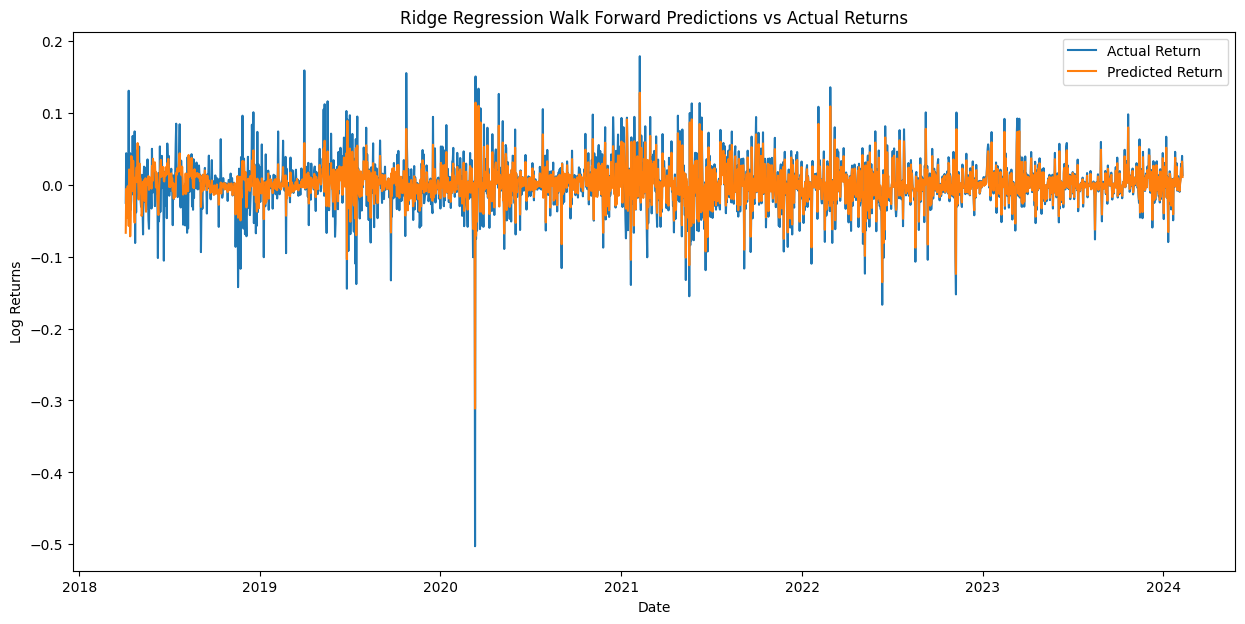

In [33]:
import matplotlib.pyplot as plt
import pandas as pd 

results_df = pd.read_csv('data/ridge_walk_forward_results.csv')
results_df['Date'] = pd.to_datetime(results_df['Date'])
plt.figure(figsize=(15, 7))
plt.plot(results_df['Date'], results_df['Actual_Return'], label='Actual Return')
plt.plot(results_df['Date'], results_df['Predicted_Return'], label='Predicted Return')
plt.title('Ridge Regression Walk Forward Predictions vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.show();

In [67]:
returns = backtest_strategy(results_df)
metrics = get_metrics(returns)

In [68]:
metrics

Winning Rate      0.962963
Loosing Rate      0.037037
Max Profit        0.416780
Max Loss         -0.066895
Avg Profit        0.046099
Avg Loss         -0.010853
Expectancy      110.440019
dtype: float64

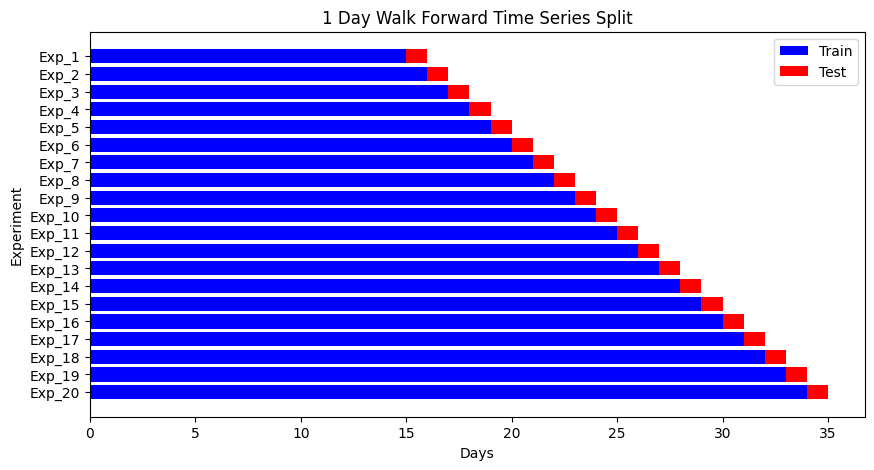

In [26]:
## Generating a walk forward time series split plot 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

start = 15
train = [start+ i for i in range(20)]
test = [1 for i in range(20)]
ts_data = pd.DataFrame({'train': train, 'test': test})
ts_data['Exp'] = [f'Exp_{i+1}' for i in range(len(ts_data))]

# Stacked bar plot 
plt.figure(figsize=(10, 5))
plt.barh(ts_data['Exp'], ts_data['train'], color='b', label='Train')
plt.barh(ts_data['Exp'], ts_data['test'], left=ts_data['train'], color='r', label='Test')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Days')
plt.ylabel('Experiment')
plt.title('1 Day Walk Forward Time Series Split');

